# Loading the Data and Model

In [1]:
"""Arguments"""
data_dir = "data"
min_occurrences = 5
num_layers = 2
tanh_after = True
is_normalized = False
checkpoint_number = 20
output_dir = "output/tanh_after_batch_50_dropout_0.3_num_layers_2_lr_0.0001"
gpu = 0

In [2]:
import os
import torch
import torchvision.transforms as transforms

from lib.utils.process_data import load_data
from lib.utils.vocabulary import load_vocab
from lib.utils.data_loader import get_loader
from lib.models.model import Model

""" Loading Data """
with open("data/raw/paragraphs_v1.json", "r") as f:
    paragraphs_json = json.load(f)
train_data, val_data, test_data, image_ids, topic_set = load_data(data_dir)
data = {'train': train_data, 'val': val_data, 'test': test_data}
transform = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(), 
        transforms.RandomVerticalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225])
    ])
}
vocabs = load_vocab(data_dir, min_occurrences=min_occurrences)
data_loaders = {
    x: get_loader(data[x], 1, vocabs, data_dir, transform[x], max_size=100) for x in ['train', 'val', 'test']
}

""" Defining Model and Training Variables """
device = torch.device("cuda:{}".format(gpu))
model = Model(512, 196, 512, 512, len(vocabs['word_vocab']), len(vocabs['topic_vocab']), num_layers=num_layers, tanh_after=tanh_after, is_normalized=is_normalized)
checkpoint = torch.load(os.path.join(output_dir, "checkpoint_{}.pt".format(checkpoint_number)))
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
train_iter, val_iter, test_iter = iter(data_loaders['train']), iter(data_loaders['val']), iter(data_loaders['test'])

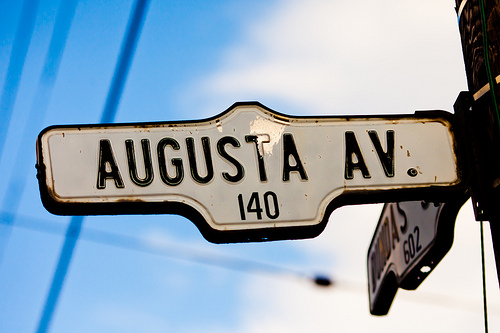

topic: signage
OUTPUTS:
this is an image of a stop sign .
the numbers on the clock are black .
this is an image of a bus stop .
this is an image of a speed limit sign .
this is an image of a city street .
this is an image of a sign .
this is an image of a street sign .
this is an image of a street .
this is an image of a clock .
this is an image of a stop sign . there is a stop sign .
TARGETS:
a white street sign has curves on the top and bottom of the sign .

topics: body, emotion, transportation, people, color, activity, food, setting, animal, signage, weather, clothing


In [21]:
from run import run
from IPython.display import display
from IPython.display import Image as DisplayImage
import random

target_topic = None

if target_topic is not None:
    target = torch.LongTensor([vocabs['topic_vocab'](target_topic)])
    data = next(val_iter)
    while(not data['topics'].equals(target)):
        data = next(val_iter)
else:
    data = next(val_iter)
    
image_id = data['image_ids'][0]
display(DisplayImage(paragraphs_json[image_ids[image_id]]['url']))
run(model, data, vocabs, device)
print("")
print("topics: " + ", ".join([x for x in topic_set]))

In [22]:
topic = "color"
data['topics'] = torch.LongTensor([vocabs['topic_vocab'](topic)])
run(model, data, vocabs, device)

topic: color
OUTPUTS:
he is wearing a short sleeve shirt and black shorts .
he is wearing a short sleeve shirt and black pants .
he is wearing a short sleeve shirt and shorts .
this is an image of a city street .
the signs are black and white .
this is an image of a street .
this is an image of a black and white street sign .
this is an image of a black and white bus .
this is an image of a black and white image of a street .
this is an image of a black and white sign .
TARGETS:
a white street sign has curves on the top and bottom of the sign .


Seems like most of the generations are conditioned on both the image and the topic
The generations usually have incorrect colors
For some topics such as color, the generations are generic following the pattern of "he is wearing a short sleeve `color` shirt and `color` shorts" even if the generation is not applicable